Import Necessary Libraries

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
%matplotlib inline

# Load Dataset

In [13]:
def load_data(file_path):
    return pd.read_csv(file_path)

# Load datasets
titanic_df = load_data("titanic.csv")
application_train_df = load_data("application_train.csv")

print(titanic_df.shape)  # (891, 12)
print(application_train_df.shape)  # (307511, 122)


(891, 12)
(139749, 122)


# Handle Missing Values

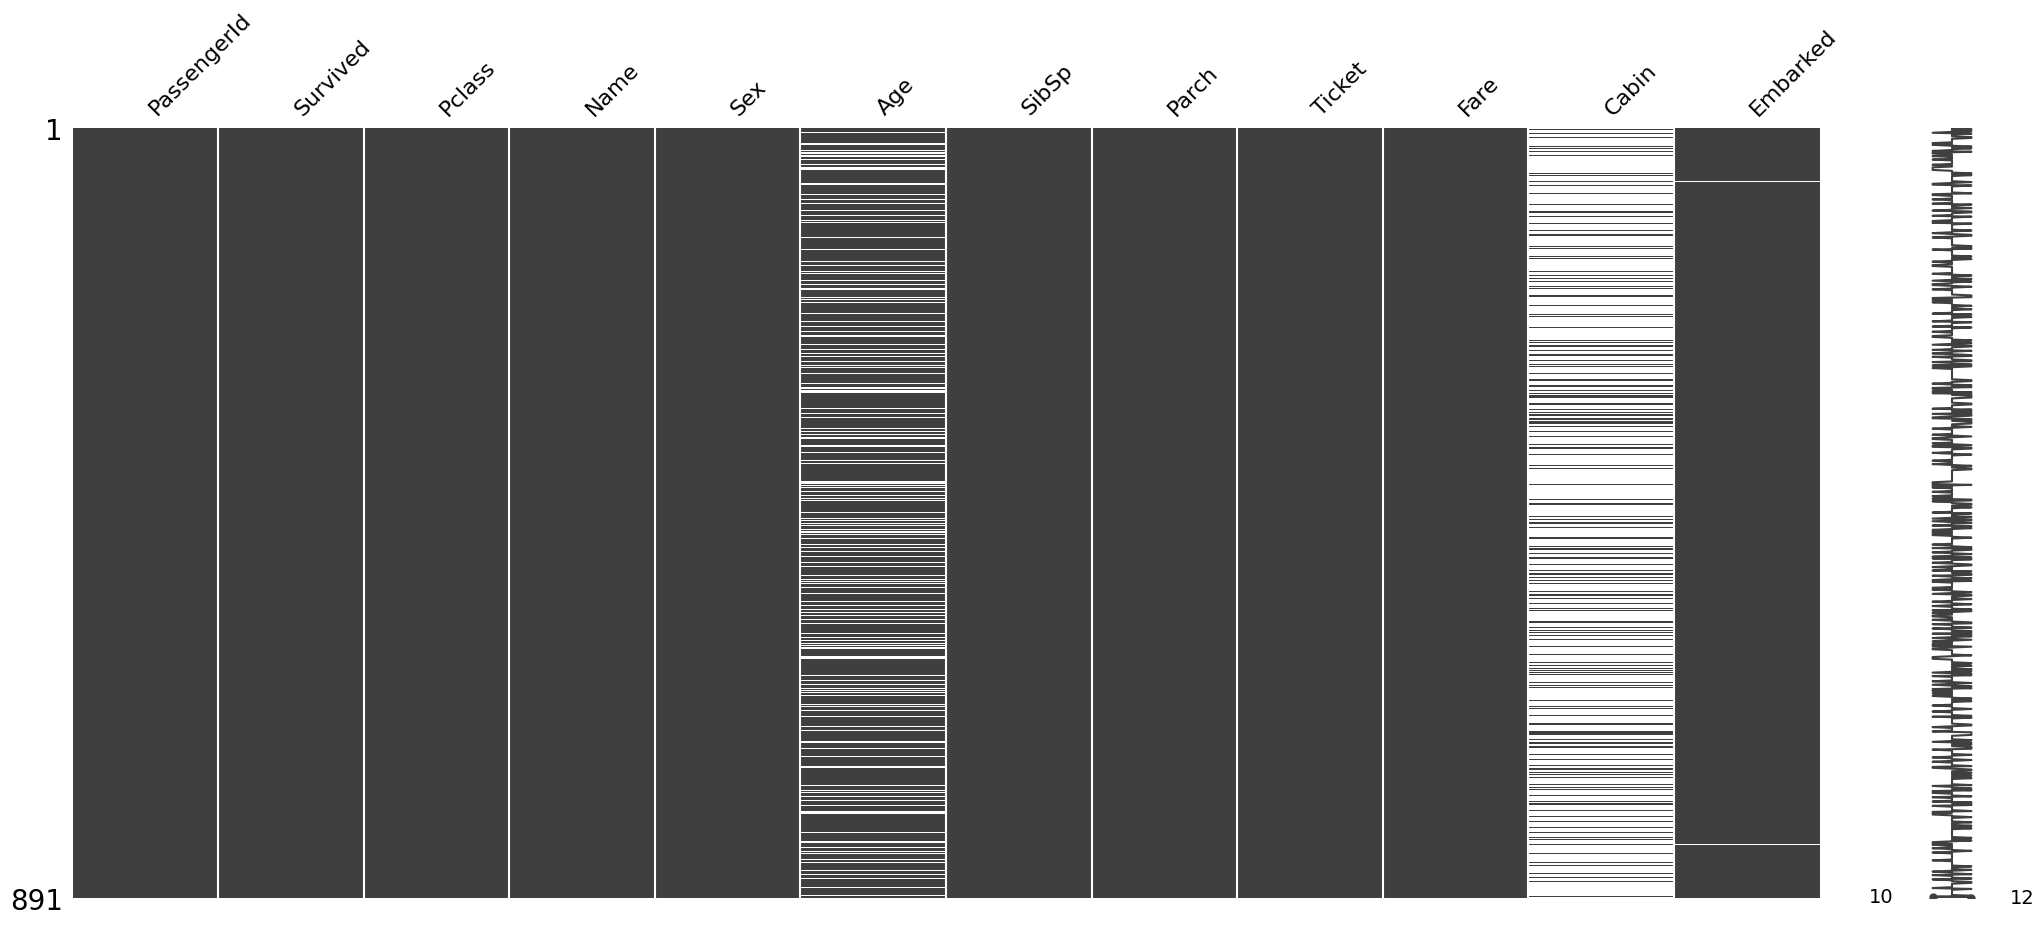

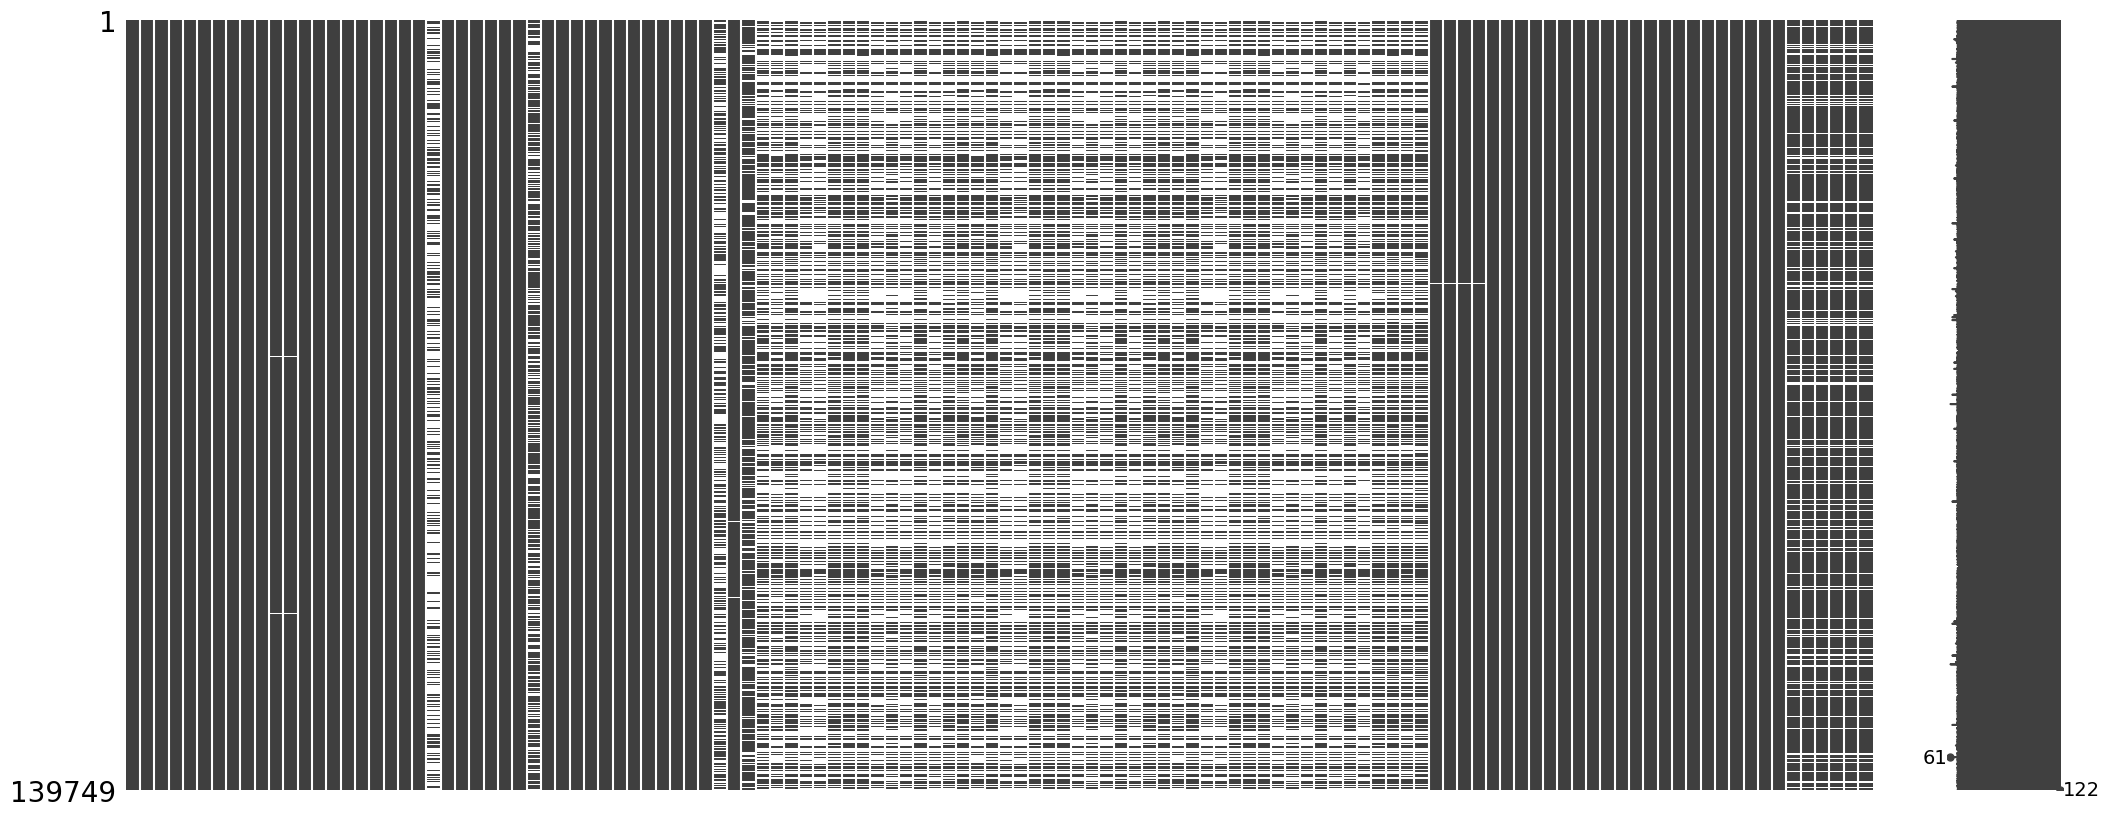

In [14]:
# Visualize missing values
msno.matrix(titanic_df)
plt.show()

msno.matrix(application_train_df)
plt.show()

# Drop columns with too many missing values
def drop_columns_with_missing_values(dataframe, threshold=0.5):
    missing_ratio = dataframe.isnull().sum() / len(dataframe)
    columns_to_drop = missing_ratio[missing_ratio > threshold].index
    return dataframe.drop(columns_to_drop, axis=1)

titanic_df = drop_columns_with_missing_values(titanic_df)
application_train_df = drop_columns_with_missing_values(application_train_df)

# Impute missing values
def impute_missing_values(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype == "O":  # Categorical
            dataframe[col].fillna(dataframe[col].mode()[0], inplace=True)
        else:  # Numerical
            dataframe[col].fillna(dataframe[col].median(), inplace=True)

impute_missing_values(titanic_df)
impute_missing_values(application_train_df)


# Detect and Handle Outliers
Boxplot and IQR Method

In [15]:
# Function to calculate IQR and detect outliers
def outlier_thresholds(dataframe, col_name):
    quartile1 = dataframe[col_name].quantile(0.25)
    quartile3 = dataframe[col_name].quantile(0.75)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Function to replace outliers with thresholds
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Apply to numeric columns in Titanic dataset
for col in titanic_df.select_dtypes(include=['float64', 'int64']).columns:
    replace_with_thresholds(titanic_df, col)

# Apply to numeric columns in Application Train dataset
for col in application_train_df.select_dtypes(include=['float64', 'int64']).columns:
    replace_with_thresholds(application_train_df, col)


# Local Outlier Factor (LOF)

In [16]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

# Function to apply LOF
def apply_lof(dataframe, n_neighbors=20):
    clf = LocalOutlierFactor(n_neighbors=n_neighbors)
    dataframe['LOF_Score'] = clf.fit_predict(dataframe.select_dtypes(include=['float64', 'int64']))
    return dataframe

# Apply LOF to numerical columns
titanic_df = apply_lof(titanic_df)
application_train_df = apply_lof(application_train_df)

# Remove LOF outliers
titanic_df = titanic_df[titanic_df['LOF_Score'] == 1].copy()
application_train_df = application_train_df[application_train_df['LOF_Score'] == 1].copy()

# Drop LOF score columns after filtering
titanic_df.drop('LOF_Score', axis=1, inplace=True)
application_train_df.drop('LOF_Score', axis=1, inplace=True)


# Feature Engineering

In [17]:
# Create new features
def feature_engineering(dataframe):
    dataframe['Family_Size'] = dataframe['SibSp'] + dataframe['Parch'] + 1
    dataframe['Is_Alone'] = np.where(dataframe['Family_Size'] == 1, 1, 0)
    return dataframe

# Apply to Titanic dataset
titanic_df = feature_engineering(titanic_df)

# For Application Train dataset, create a similar feature set
application_train_df['Total_Income'] = application_train_df['AMT_INCOME_TOTAL'] + application_train_df['AMT_CREDIT']
application_train_df['Age_Years'] = application_train_df['DAYS_BIRTH'] / -365
application_train_df['Years_Employed'] = application_train_df['DAYS_EMPLOYED'] / -365


# **Exploratory Data Analysis (EDA)**

In [18]:
# Titanic dataset
print(titanic_df.describe())
print(titanic_df.info())

# Application Train dataset
print(application_train_df.describe())
print(application_train_df.info())


       PassengerId    Survived      Pclass         Age       SibSp  Parch  \
count   885.000000  885.000000  885.000000  885.000000  885.000000  885.0   
mean    446.861017    0.381921    2.312994   29.083616    0.421469    0.0   
std     257.784206    0.486132    0.833613   11.952811    0.702929    0.0   
min       1.000000    0.000000    1.000000    2.500000    0.000000    0.0   
25%     223.000000    0.000000    2.000000   22.000000    0.000000    0.0   
50%     449.000000    0.000000    3.000000   28.000000    0.000000    0.0   
75%     670.000000    1.000000    3.000000   35.000000    1.000000    0.0   
max     891.000000    1.000000    3.000000   54.500000    2.500000    0.0   

             Fare  Family_Size    Is_Alone  
count  885.000000   885.000000  885.000000  
mean    23.877264     1.421469    0.684746  
std     20.400902     0.702929    0.464880  
min      0.000000     1.000000    0.000000  
25%      7.895800     1.000000    0.000000  
50%     14.454200     1.000000    1.

# Univariate Analysis


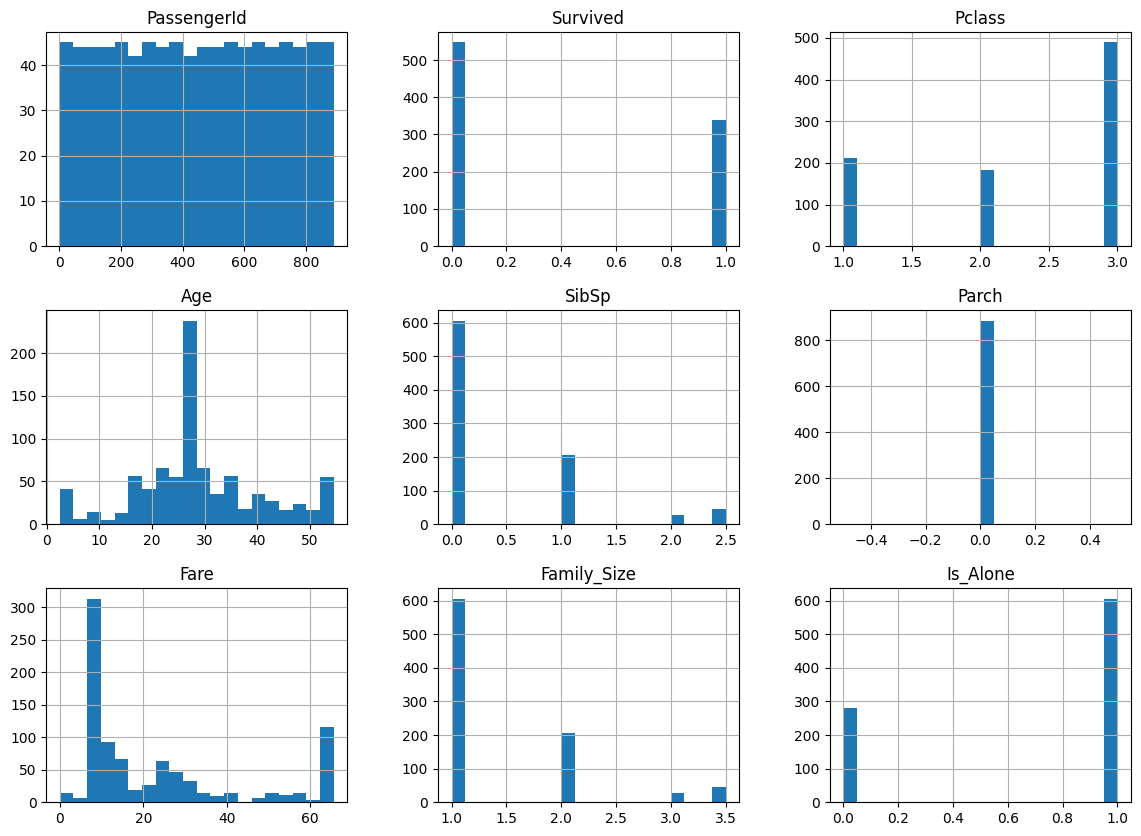

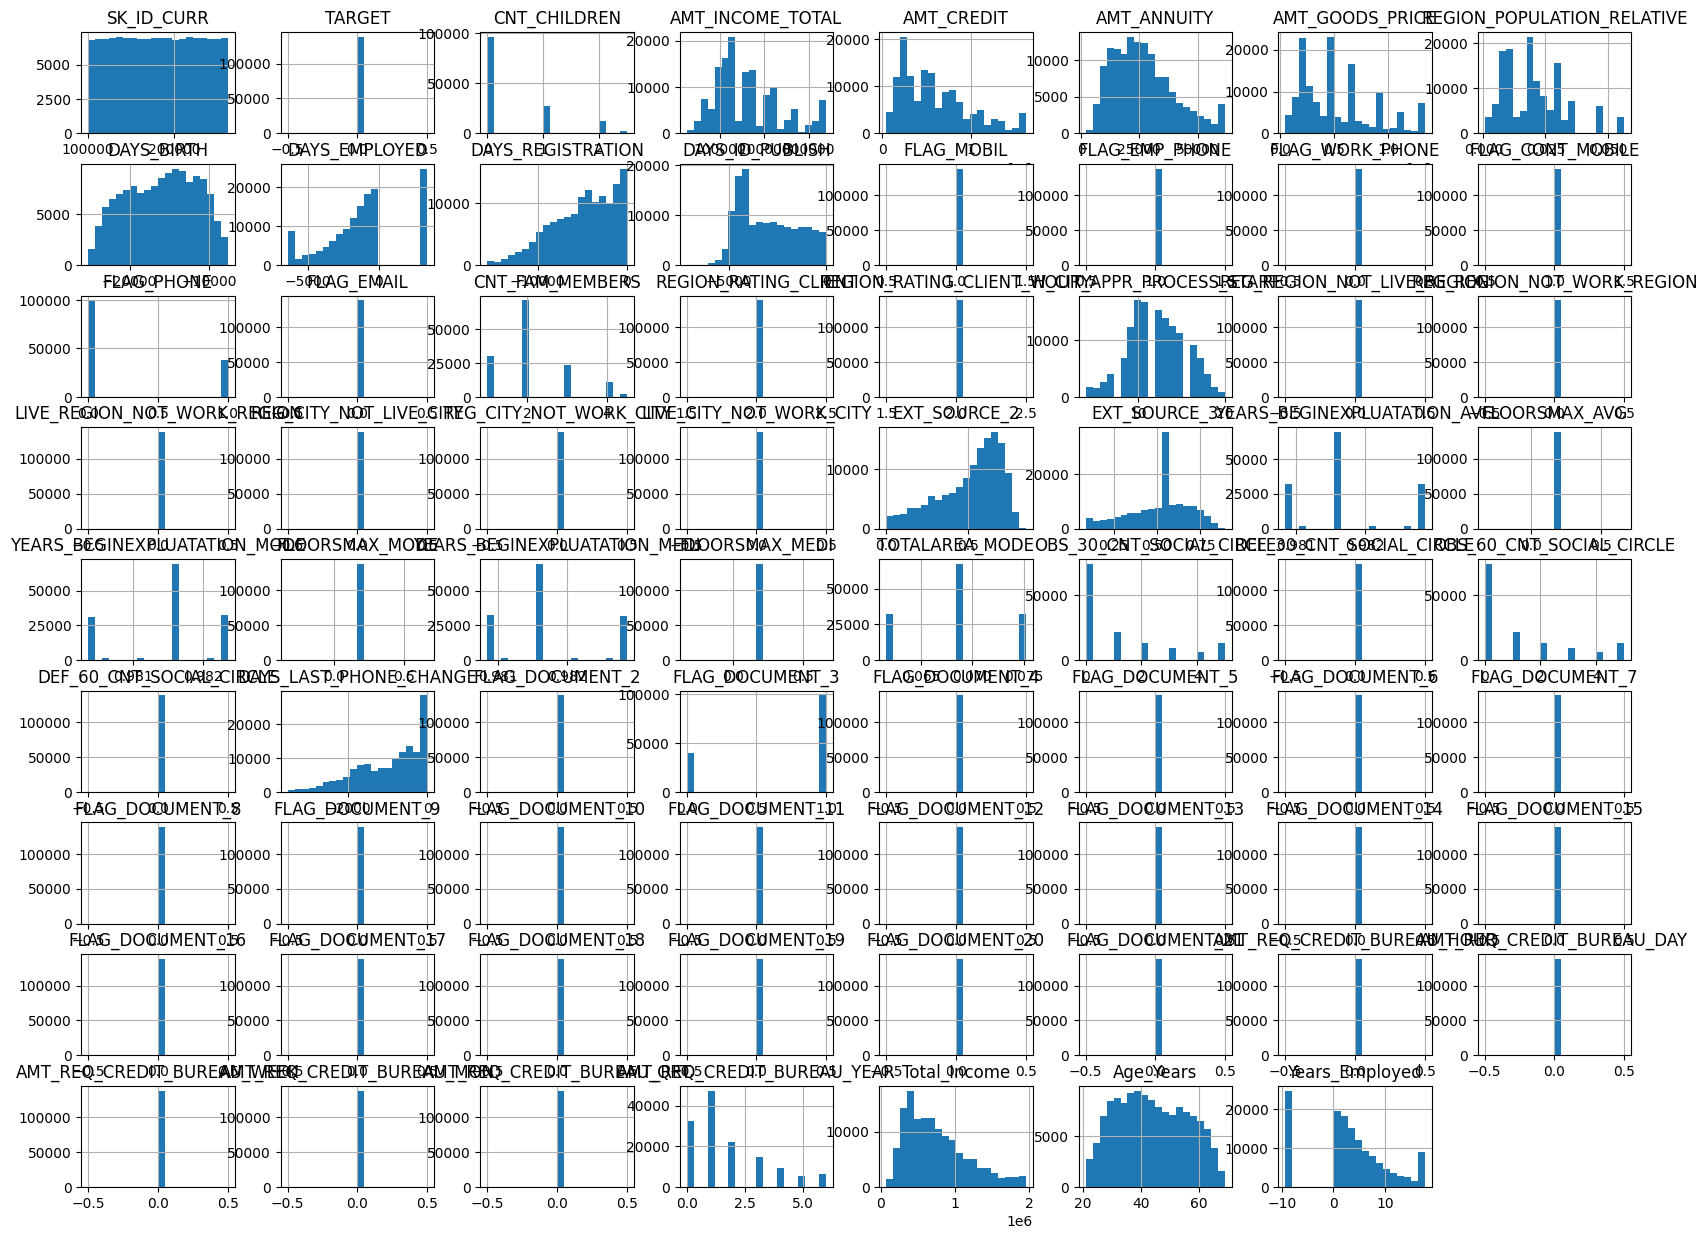

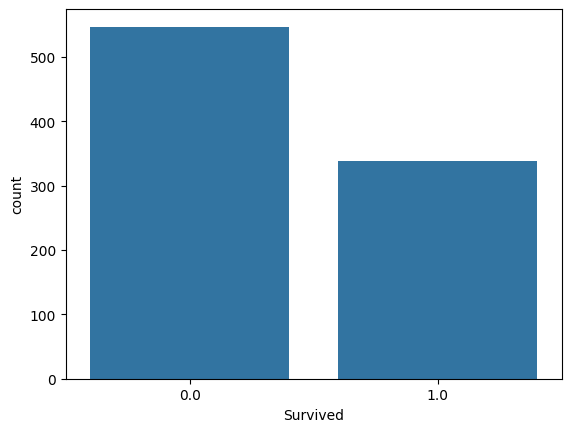

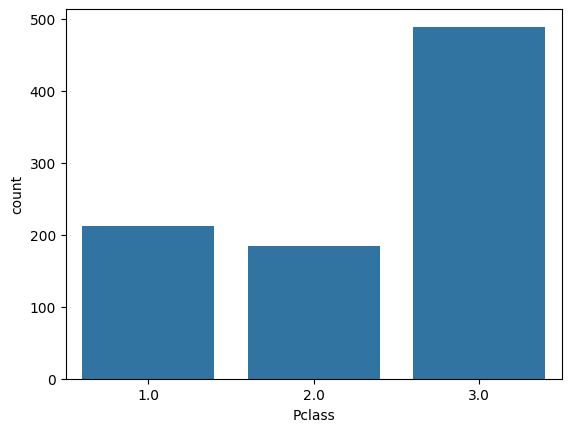

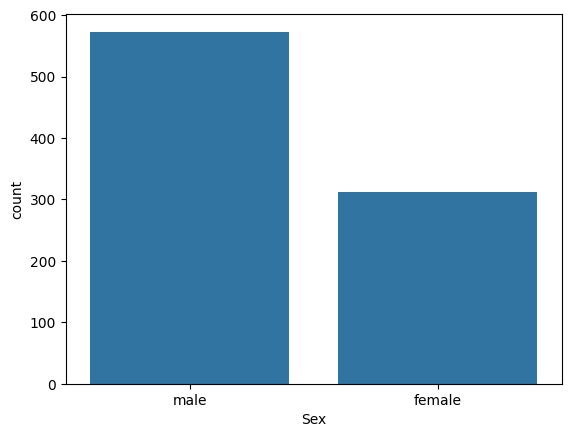

In [19]:
# Histograms for numerical variables
titanic_df.hist(bins=20, figsize=(14, 10))
plt.show()

application_train_df.hist(bins=20, figsize=(20, 15))
plt.show()

# Count plots for categorical variables
sns.countplot(x='Survived', data=titanic_df)
plt.show()

sns.countplot(x='Pclass', data=titanic_df)
plt.show()

sns.countplot(x='Sex', data=titanic_df)
plt.show()


#Bivariate Analysis

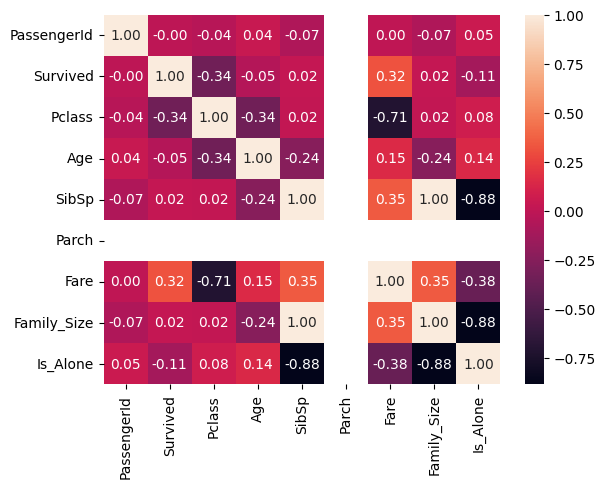

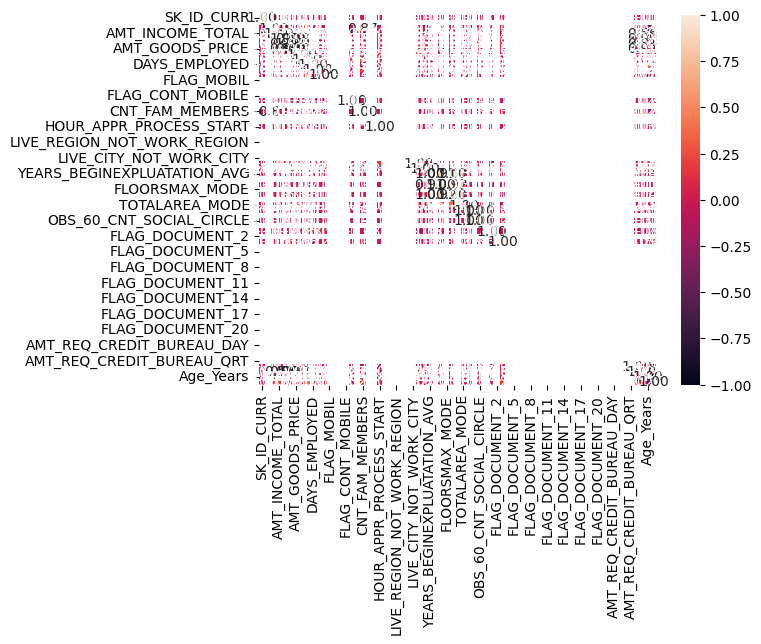

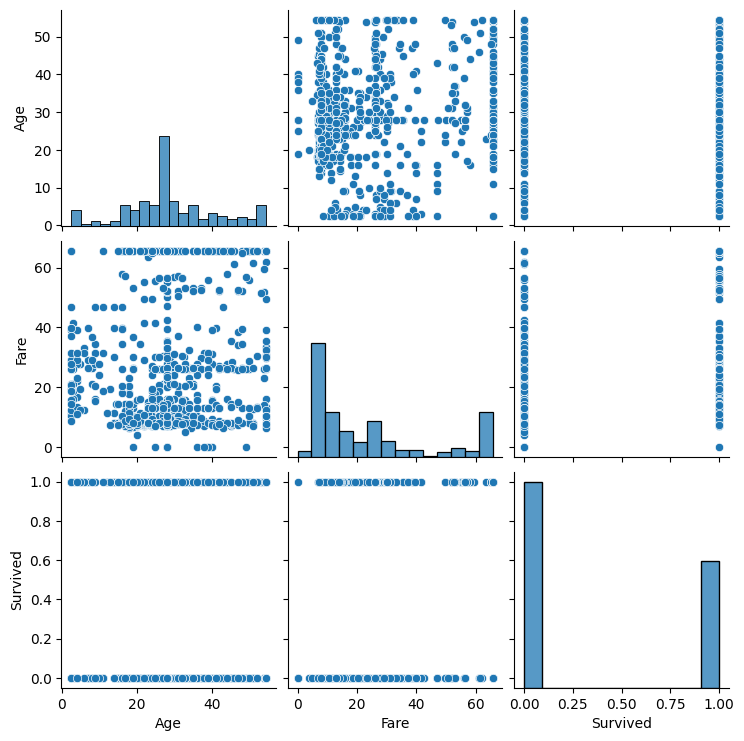

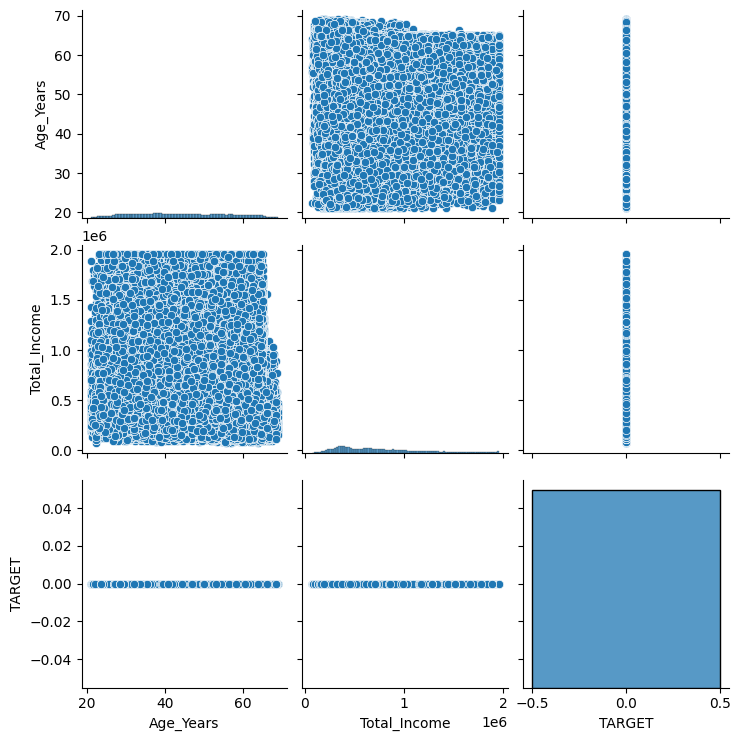

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation matrix
titanic_corr = titanic_df.select_dtypes(include=['float64', 'int64']).corr()
application_train_corr = application_train_df.select_dtypes(include=['float64', 'int64']).corr()

# Heatmap for Titanic dataset
sns.heatmap(titanic_corr, annot=True, fmt=".2f")
plt.show()

# Heatmap for Application Train dataset
sns.heatmap(application_train_corr, annot=True, fmt=".2f")
plt.show()

# Pairplot for selected features in Titanic dataset
sns.pairplot(titanic_df[['Age', 'Fare', 'Survived']])
plt.show()

# Pairplot for selected features in Application Train dataset
sns.pairplot(application_train_df[['Age_Years', 'Total_Income', 'TARGET']])
plt.show()


#  Encoding Categorical Variables


In [22]:
# Label Encoding for binary variables
def label_encoding(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

titanic_df = label_encoding(titanic_df, 'Sex')

# One-Hot Encoding for categorical variables
titanic_df = pd.get_dummies(titanic_df, drop_first=True)
application_train_df = pd.get_dummies(application_train_df, drop_first=True)


# Scaling Features

In [23]:
# Standard Scaling
scaler = StandardScaler()
titanic_df[['Age', 'Fare']] = scaler.fit_transform(titanic_df[['Age', 'Fare']])
application_train_df[['Total_Income', 'Age_Years', 'Years_Employed']] = scaler.fit_transform(application_train_df[['Total_Income', 'Age_Years', 'Years_Employed']])


In [24]:
# Titanic dataset
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Application Train dataset
X = application_train_df.drop('TARGET', axis=1)
y = application_train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
X_train, X_test, y_train, y_test

(        SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
 109082    226514.0           0.0          157500.0    269550.0      24853.5   
 20148     123501.0           0.0          315000.0    405000.0      28188.0   
 123376    243072.0           0.0          112500.0    135000.0       6750.0   
 36575     142357.0           2.5          270000.0    599778.0      30753.0   
 101162    217455.0           0.0          135000.0    427450.5      33696.0   
 ...            ...           ...               ...         ...          ...   
 111529    229400.0           0.0          135000.0    770292.0      35824.5   
 121239    240560.0           0.0          112500.0    385164.0      20295.0   
 104886    221711.0           1.0          315000.0    566055.0      20925.0   
 133463    254790.0           0.0          135000.0    101880.0      10053.0   
 123353    243049.0           0.0           99000.0    284400.0      19134.0   
 
         AMT_GOODS_PRICE  REGION_POPUL

# **Titanic Dataset Feature Engineering and EDA**

In [29]:
import pandas as pd
import numpy as np

# Load Titanic dataset
titanic_df = pd.read_csv('titanic.csv')

# Feature: Family Size
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

# Feature: IsAlone
titanic_df['IsAlone'] = 1  # Initialize to 1
titanic_df.loc[titanic_df['FamilySize'] > 1, 'IsAlone'] = 0  # Set to 0 if FamilySize > 1

# Feature: Title Extraction
titanic_df['Title'] = titanic_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
title_mapping = {
    'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6,
    'Major': 7, 'Col': 8, 'Mlle': 9, 'Mme': 10, 'Ms': 11, 'Lady': 12,
    'Sir': 13, 'Capt': 14, 'Countess': 15, 'Jonkheer': 16, 'Don': 17
}
titanic_df['Title'] = titanic_df['Title'].map(title_mapping).fillna(0)

# Feature: Fare Per Person
titanic_df['FarePerPerson'] = titanic_df['Fare'] / titanic_df['FamilySize']

# Feature: Age Groups
titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins=[0, 12, 18, 35, 60, 120], labels=[0, 1, 2, 3, 4])

# Feature: Cabin Deck
titanic_df['CabinDeck'] = titanic_df['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'U')

# Check the new features
print(titanic_df[['FamilySize', 'IsAlone', 'Title', 'FarePerPerson', 'AgeGroup', 'CabinDeck']].head())


   FamilySize  IsAlone  Title  FarePerPerson AgeGroup CabinDeck
0           2        0    1.0        3.62500        2         U
1           2        0    3.0       35.64165        3         C
2           1        1    2.0        7.92500        2         U
3           2        0    3.0       26.55000        2         C
4           1        1    1.0        8.05000        2         U


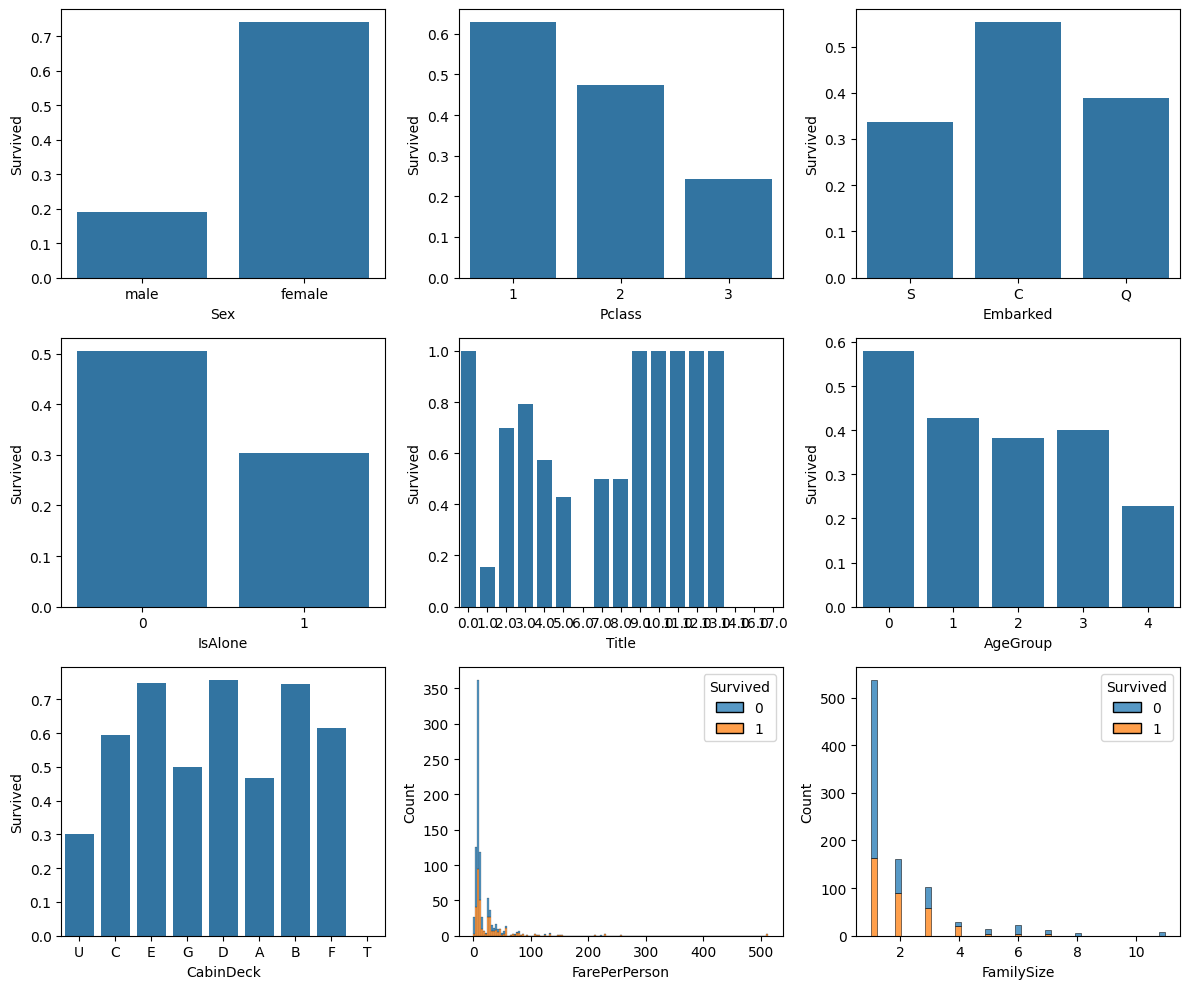

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
plt.subplot(3, 3, 1)
sns.barplot(x='Sex', y='Survived', data=titanic_df, errorbar=None)
plt.subplot(3, 3, 2)
sns.barplot(x='Pclass', y='Survived', data=titanic_df, errorbar=None)
plt.subplot(3, 3, 3)
sns.barplot(x='Embarked', y='Survived', data=titanic_df, errorbar=None)
plt.subplot(3, 3, 4)
sns.barplot(x='IsAlone', y='Survived', data=titanic_df, errorbar=None)
plt.subplot(3, 3, 5)
sns.barplot(x='Title', y='Survived', data=titanic_df, errorbar=None)
plt.subplot(3, 3, 6)
sns.barplot(x='AgeGroup', y='Survived', data=titanic_df, errorbar=None)
plt.subplot(3, 3, 7)
sns.barplot(x='CabinDeck', y='Survived', data=titanic_df, errorbar=None)
plt.subplot(3, 3, 8)
sns.histplot(data=titanic_df, x='FarePerPerson', hue='Survived', multiple='stack')
plt.subplot(3, 3, 9)
sns.histplot(data=titanic_df, x='FamilySize', hue='Survived', multiple='stack')
plt.tight_layout()
plt.show()

# Save the processed dataset
titanic_df.to_csv('titanic_processed.csv', index=False)


#Application Train Dataset Feature Engineering and EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


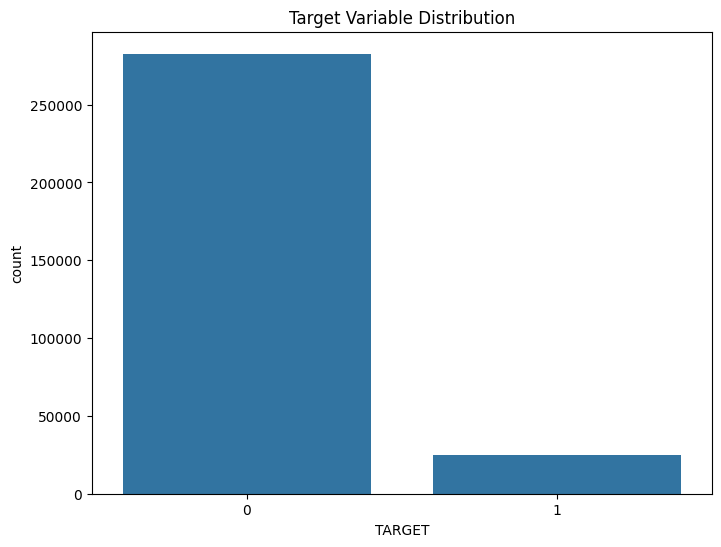

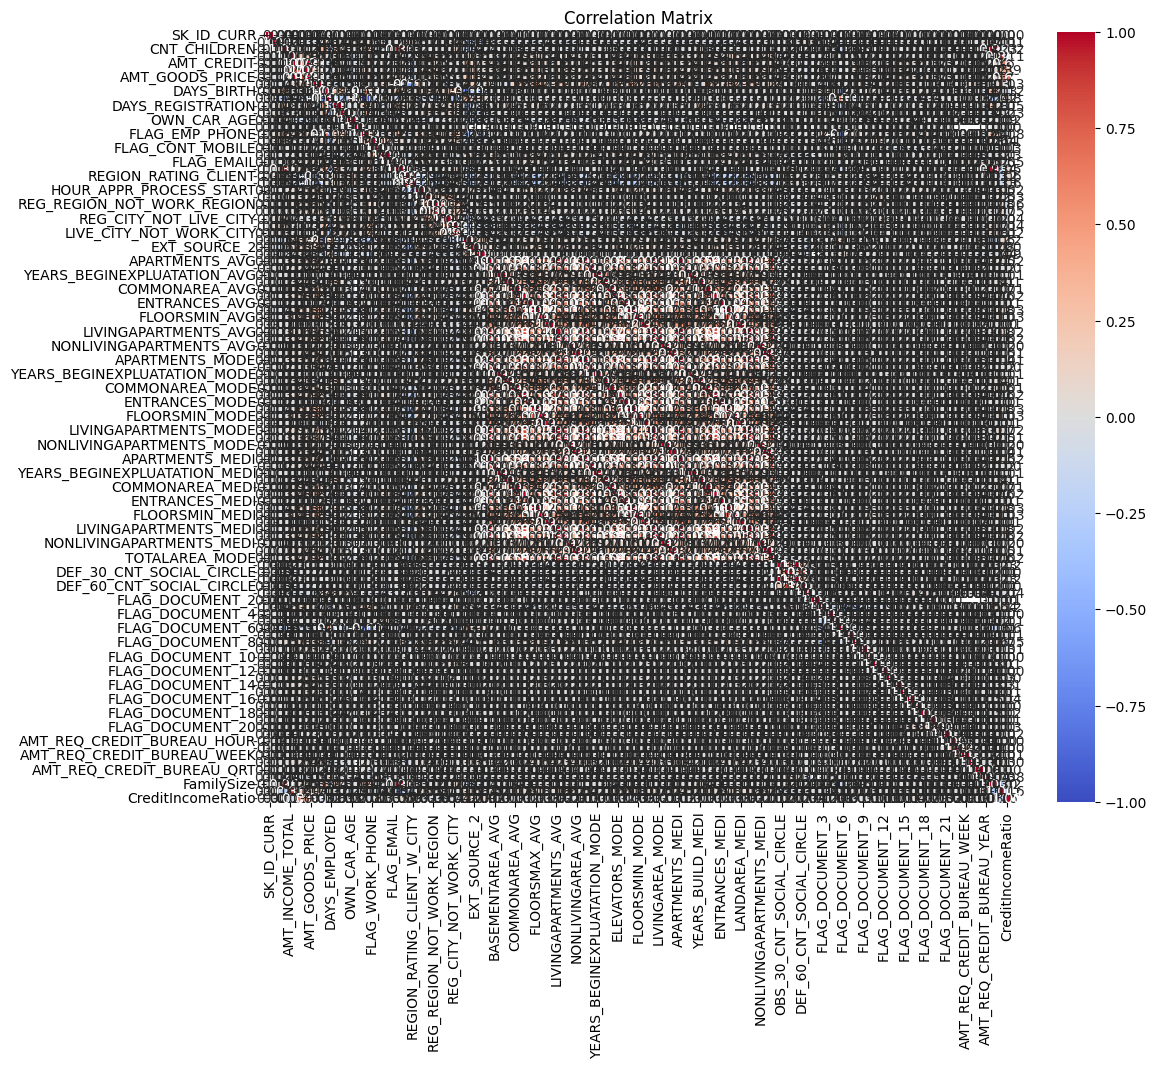

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load Application Train dataset
train_df = pd.read_csv('application_train.csv')

# Display basic information about the dataset
print(train_df.info())

# Feature: Family Size
train_df['FamilySize'] = train_df['CNT_CHILDREN'] + train_df['CNT_FAM_MEMBERS']

# Feature: Income Per Person
train_df['IncomePerPerson'] = train_df['AMT_INCOME_TOTAL'] / train_df['CNT_FAM_MEMBERS']

# Feature: Credit Income Ratio
train_df['CreditIncomeRatio'] = train_df['AMT_CREDIT'] / train_df['AMT_INCOME_TOTAL']

# Select numeric columns only for correlation matrix
numeric_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = train_df[numeric_columns].corr()

# EDA: Visualize target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=train_df)
plt.title('Target Variable Distribution')
plt.show()

# EDA: Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Save the processed dataset
train_df.to_csv('application_train_processed.csv', index=False)


<ipython-input-35-33c68b3816b1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TARGET', data=train_df, palette='Set1')


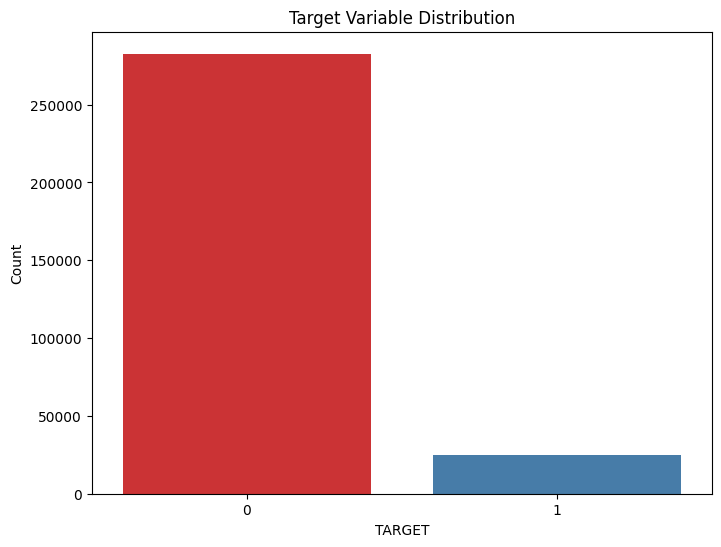

Percentage of defaulters: 8.07%


In [35]:
# Check the distribution of the target variable (assuming 'TARGET' is the target column)
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=train_df, palette='Set1')
plt.title('Target Variable Distribution')
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.show()

# Calculate the percentage of defaulters
defaulter_percentage = train_df['TARGET'].mean() * 100
print(f"Percentage of defaulters: {defaulter_percentage:.2f}%")


<ipython-input-36-33c68b3816b1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TARGET', data=train_df, palette='Set1')


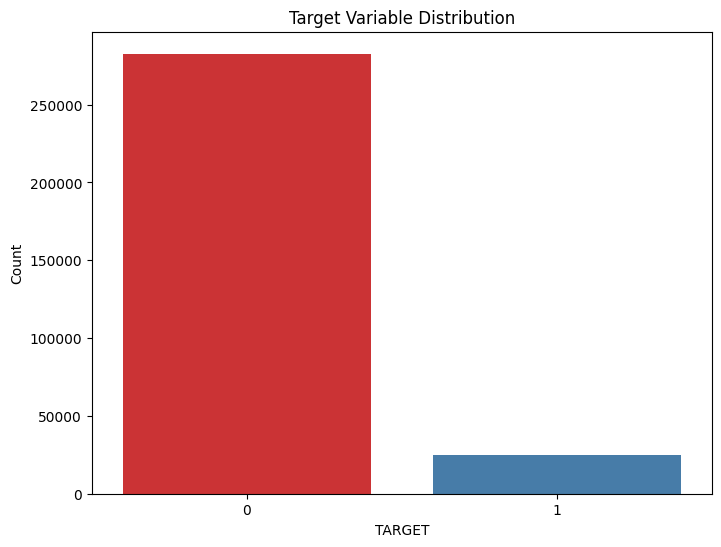

Percentage of defaulters: 8.07%


In [36]:
# Check the distribution of the target variable (assuming 'TARGET' is the target column)
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=train_df, palette='Set1')
plt.title('Target Variable Distribution')
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.show()

# Calculate the percentage of defaulters
defaulter_percentage = train_df['TARGET'].mean() * 100
print(f"Percentage of defaulters: {defaulter_percentage:.2f}%")


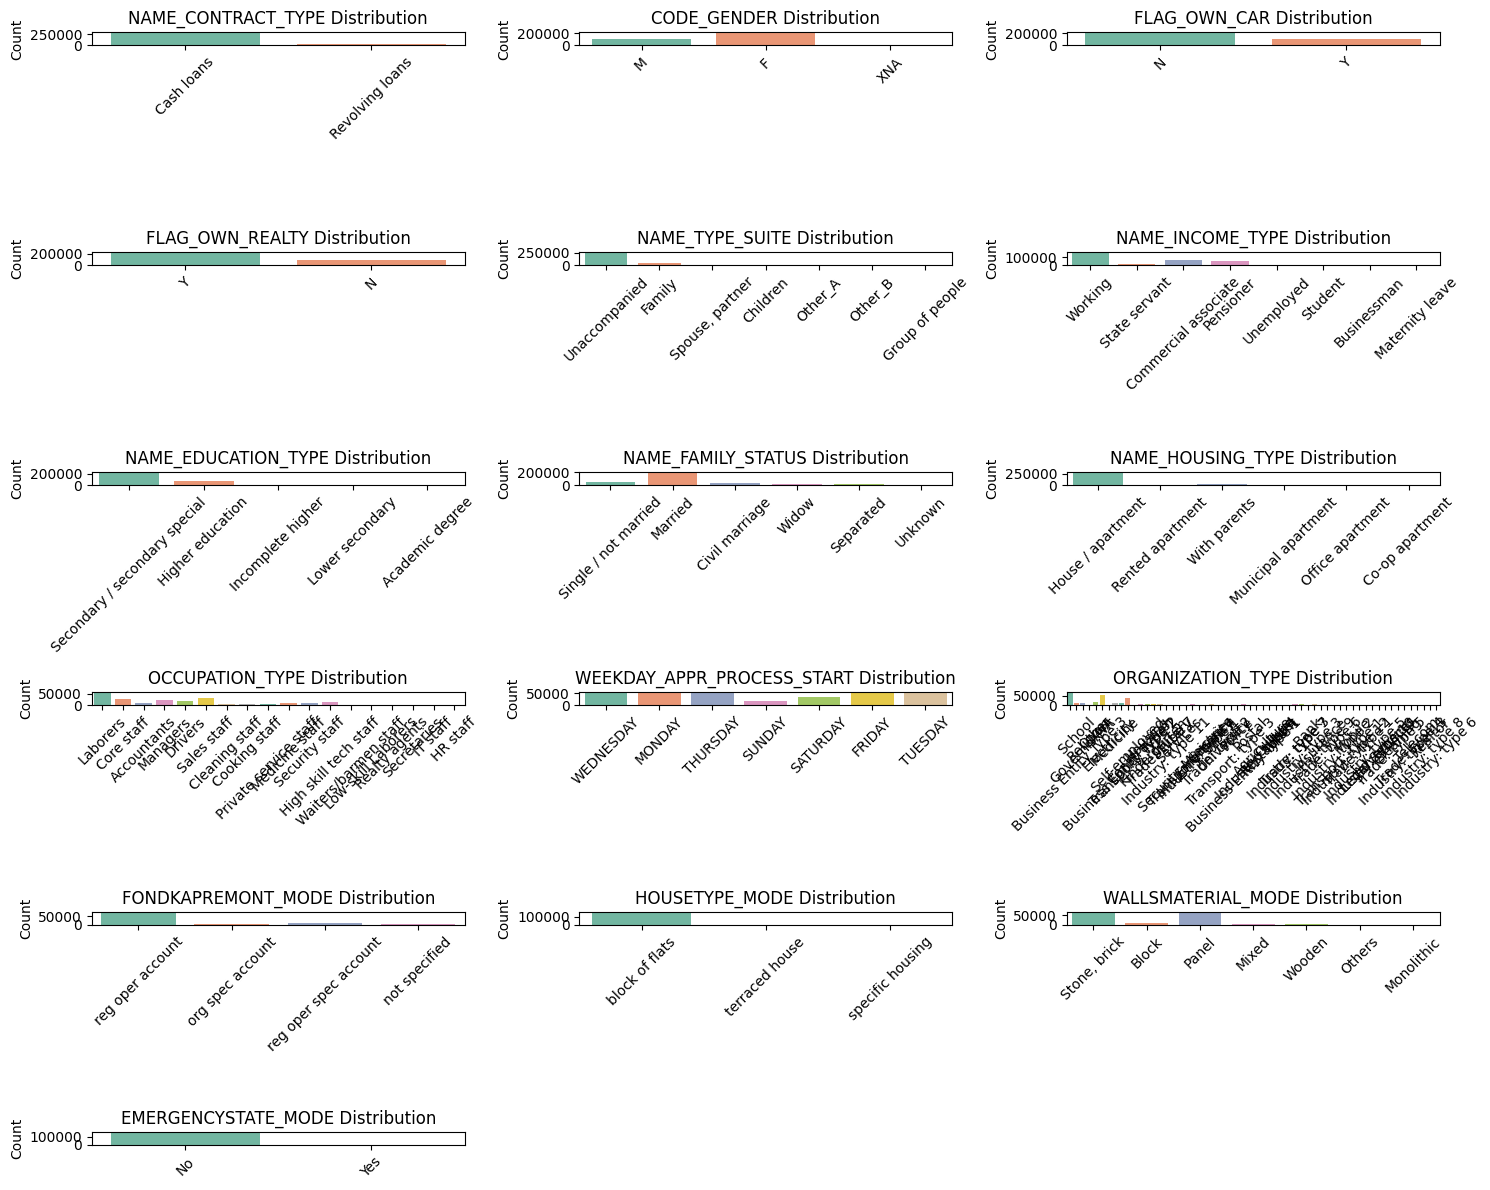

In [51]:
import math
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
warnings.filterwarnings("ignore")

# Determine number of rows and columns for subplots
categorical_features = train_df.select_dtypes(include=['object']).columns
num_features = len(categorical_features)
num_rows = math.ceil(num_features / 3)
num_cols = min(num_features, 3)

# Count plot for categorical features
plt.figure(figsize=(15, 12))  # Adjusted figure size for better visibility
for i, col in enumerate(categorical_features, start=1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(x=col, data=train_df, palette='Set2')
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
    plt.xlabel('')  # Clear xlabel for better layout
    plt.ylabel('Count')  # Adding ylabel for clarity
    plt.tight_layout()  # Ensures better layout spacing

plt.show()


In [52]:
# Example of creating new features
train_df['Total_Income'] = train_df['AMT_INCOME_TOTAL'] + train_df['AMT_ANNUITY']
train_df['Age_Years'] = train_df['DAYS_BIRTH'] / -365
train_df['Years_Employed'] = train_df['DAYS_EMPLOYED'] / -365

# Check the newly created features
print(train_df[['Total_Income', 'Age_Years', 'Years_Employed']].head())


   Total_Income  Age_Years  Years_Employed
0      227200.5  25.920548        1.745205
1      305698.5  45.931507        3.254795
2       74250.0  52.180822        0.616438
3      164686.5  52.068493        8.326027
4      143365.5  54.608219        8.323288


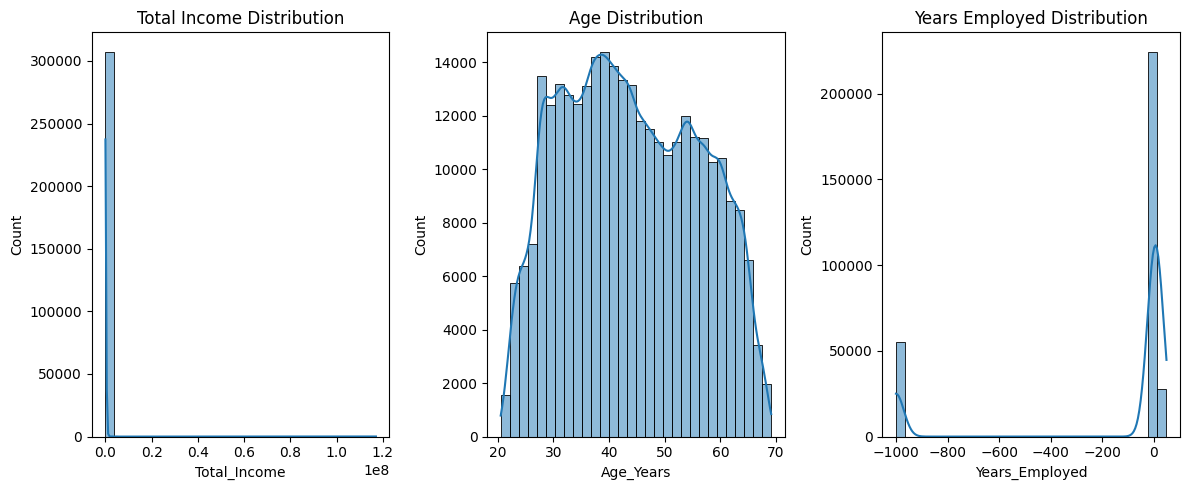

In [53]:
# Visualize new features
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.histplot(train_df['Total_Income'], bins=30, kde=True)
plt.title('Total Income Distribution')

plt.subplot(1, 3, 2)
sns.histplot(train_df['Age_Years'], bins=30, kde=True)
plt.title('Age Distribution')

plt.subplot(1, 3, 3)
sns.histplot(train_df['Years_Employed'], bins=30, kde=True)
plt.title('Years Employed Distribution')

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

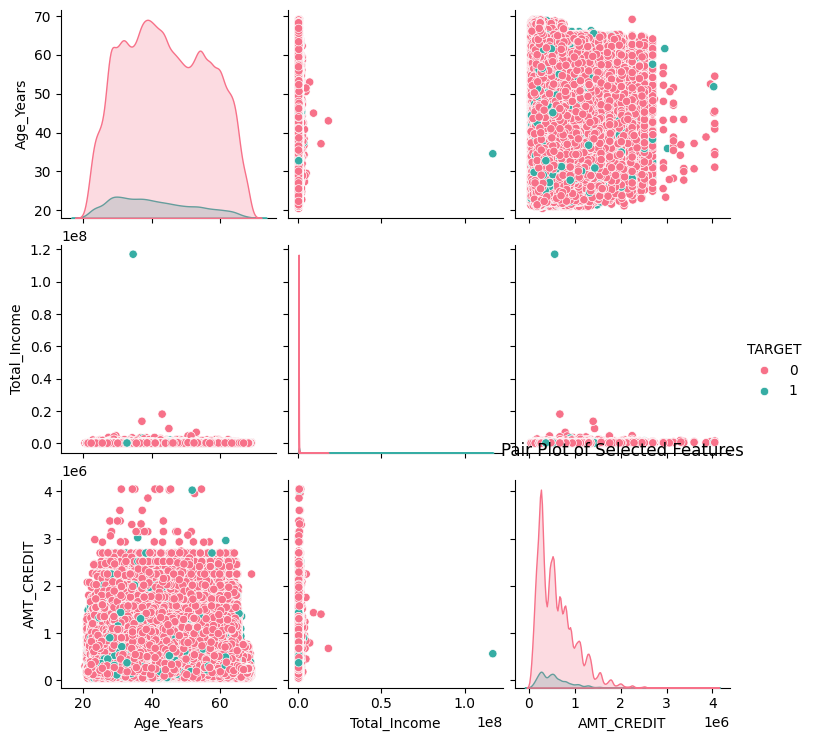

In [54]:
# Example of advanced visualizations (scatter plots, pair plots, etc.)
plt.figure(figsize=(10, 8))
sns.pairplot(train_df[['TARGET', 'Age_Years', 'Total_Income', 'AMT_CREDIT']], hue='TARGET', palette='husl')
plt.title('Pair Plot of Selected Features')
plt.show()


(53940, 10)
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
(53940, 7)
   carat  depth  table  price     x     y     z
0   0.23   61.5   55.0    326  3.95  3.98  2.43
1   0.21   59.8   61.0    326  3.89  3.84  2.31
2   0.23   56.9   65.0    327  4.05  4.07  2.31
3   0.29   62.4   58.0    334  4.20  4.23  2.63
4   0.31   63.3   58.0    335  4.34  4.35  2.75
carat True
depth True
table True
price True
x True
y True
z True
(1889, 7)
(2545, 7)
[-8.60430658 -8.20889984 -5.86084355 -4.98415175 -4.81502092]


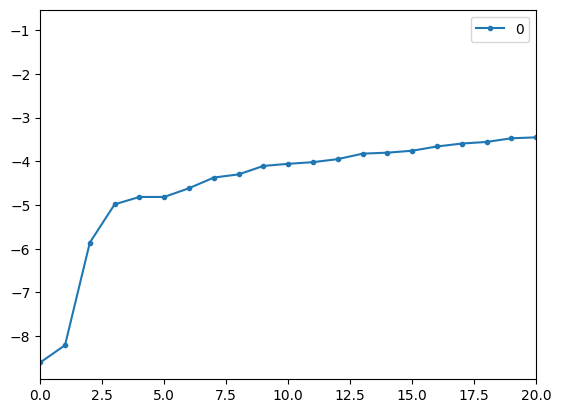

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# Function to check for outliers based on thresholds
def check_outlier(df, col):
    low, up = outlier_thresholds(df, col)
    return df[((df[col] < low) | (df[col] > up))].shape[0] > 0

# Function to calculate outlier thresholds
def outlier_thresholds(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    up = q3 + 1.5 * iqr
    return low, up

# Load diamonds dataset from seaborn
df = sns.load_dataset('diamonds')
print(df.shape)  # (53940, 10)
print(df.head())

# Remove non-numeric columns
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
print(df.shape)  # (53940, 7)
print(df.head())

# Check columns that contain outliers
for col in df.columns:
    print(col, check_outlier(df, col))

# Check how many rows contain outlier 'carat'
low, up = outlier_thresholds(df, "carat")
print(df[((df["carat"] < low) | (df["carat"] > up))].shape)  # (1889, 7)

# Check how many rows contain outlier 'depth'
low, up = outlier_thresholds(df, "depth")
print(df[((df["depth"] < low) | (df["depth"] > up))].shape)  # (2545, 7)

# Apply Local Outlier Factor (LOF) with n_neighbors=20
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_

# Sort outlier scores and visualize
print(np.sort(df_scores)[0:5])  # array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()
